In [68]:
# Need to install xgboost using terminal
# pip install xgboost

In [69]:
# !pip uninstall scikit-learn --yes
# !pip uninstall imblearn --yes
# !pip install scikit-learn==1.2.2
# !pip install imblearn

In [70]:
# importing required libraries
import pandas as pd
from pathlib import Path
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
%matplotlib inline
import joblib
from imblearn.over_sampling import SMOTE

In [71]:
# read the train and test dataset
data = Path("train.csv")
df = pd.read_csv(data)
df.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1,0,181449.97,0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1,1,49503.50,0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1,0,184866.69,0
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1,1,84560.88,0
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1,1,15068.83,0


In [72]:
#removing customers over the age of 80 
# df = df.loc[df['Age'] <= 80]
# df.value_counts

In [73]:
df.drop(['id', 'CustomerId','Surname'], axis = 1, inplace = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165034 entries, 0 to 165033
Data columns (total 11 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   CreditScore      165034 non-null  int64  
 1   Geography        165034 non-null  object 
 2   Gender           165034 non-null  object 
 3   Age              165034 non-null  float64
 4   Tenure           165034 non-null  int64  
 5   Balance          165034 non-null  float64
 6   NumOfProducts    165034 non-null  int64  
 7   HasCrCard        165034 non-null  int64  
 8   IsActiveMember   165034 non-null  int64  
 9   EstimatedSalary  165034 non-null  float64
 10  Exited           165034 non-null  int64  
dtypes: float64(3), int64(6), object(2)
memory usage: 13.9+ MB


In [74]:
# Create new columns based on the Gender column
df['Is_Male'] = df['Gender'].apply(lambda x: 1 if x == 'Male' else 0)
df['Is_Female'] = df['Gender'].apply(lambda x: 1 if x == 'Female' else 0)

# Create new columns based on the Geography column
df['Is_Germany'] = df['Geography'].apply(lambda x: 1 if x == 'Germany' else 0)
df['Is_Spain'] = df['Geography'].apply(lambda x: 1 if x == 'Spain' else 0)
df['Is_France'] = df['Geography'].apply(lambda x: 1 if x == 'France' else 0)

In [75]:
# drop non-int columns

#version 1.0 drop non int variables
df.drop(['Geography', 'Gender'], axis = 1, inplace = True)

#version 1.1 according to v1.0 Tenure and Estimated Salary did not weigh high
# df.drop(['Geography', 'Gender', 'Tenure', 'EstimatedSalary'], axis = 1, inplace = True)

#version 1.2
# df.drop(['Geography', 'Gender', 'Tenure', 'Is_Female'], axis = 1, inplace = True)

#version 1.3
# df.drop(['Geography', 'Gender', 'Tenure', 'Is_Female', 'EstimatedSalary', 'Is_France', 'Is_Spain'], axis = 1, inplace = True)

#version 1.4
# df.drop(['Geography', 'Gender', 'Tenure', 'EstimatedSalary'
            #   , 'Is_France', 'Is_Spain', 'Is_Female', 'HasCrCard', 'CreditScore'], axis = 1, inplace = True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165034 entries, 0 to 165033
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   CreditScore      165034 non-null  int64  
 1   Age              165034 non-null  float64
 2   Tenure           165034 non-null  int64  
 3   Balance          165034 non-null  float64
 4   NumOfProducts    165034 non-null  int64  
 5   HasCrCard        165034 non-null  int64  
 6   IsActiveMember   165034 non-null  int64  
 7   EstimatedSalary  165034 non-null  float64
 8   Exited           165034 non-null  int64  
 9   Is_Male          165034 non-null  int64  
 10  Is_Female        165034 non-null  int64  
 11  Is_Germany       165034 non-null  int64  
 12  Is_Spain         165034 non-null  int64  
 13  Is_France        165034 non-null  int64  
dtypes: float64(3), int64(11)
memory usage: 17.6 MB


In [76]:
# Define features set
X = df.copy()
X.drop("Exited", axis=1, inplace=True)
X.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Is_Male,Is_Female,Is_Germany,Is_Spain,Is_France
0,668,33.0,3,0.00,2,1,0,181449.97,1,0,0,0,1
1,627,33.0,1,0.00,2,1,1,49503.50,1,0,0,0,1
2,678,40.0,10,0.00,2,1,0,184866.69,1,0,0,0,1
3,581,34.0,2,148882.54,1,1,1,84560.88,1,0,0,0,1
4,716,33.0,5,0.00,2,1,1,15068.83,1,0,0,1,0


In [77]:
# select target variable
y = df["Exited"].values.reshape(-1, 1)
y[:10]

array([[0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0]], dtype=int64)

In [78]:
# Splitting into Train and Test sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)

# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=50)

In [79]:
# Initialize XGBClassifier
clf = XGBClassifier()

In [80]:
# Define the grid of hyperparameters to search
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.2]
}

In [81]:
# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=3, scoring='accuracy')
grid_search.fit(X_train, y_train)


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 4, 5],
                         'n_estimators': [50, 100, 200]},
             scoring='accuracy')

In [82]:
# Print the best hyperparameters found
print("Best Hyperparameters:", grid_search.best_params_)

Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}


In [83]:
# Evaluate the best model on the test set
best_model = grid_search.best_estimator_

accuracy = best_model.score(X_test, y_test)

print("Test Accuracy:", accuracy)

Test Accuracy: 0.8672705789680977


In [84]:
# Create the XGBoost instance using Best Hyperparameters
model = XGBClassifier(learning_rate=0.1, max_depth=5, n_estimators=100, random_state=50)

In [85]:
# Fit the model using no scaler
model = model.fit(X_train, y_train)


In [86]:
# Making predictions using the testing data
predictions = model.predict(X_test)

In [87]:
# Calculating the confusion matrix
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
)

# Calculating the accuracy score
acc_score = accuracy_score(y_test, predictions)

In [88]:
# Displaying results
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, predictions))

Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,24748,1349
Actual 1,3032,3878


Accuracy Score : 0.8672705789680977
Classification Report
              precision    recall  f1-score   support

           0       0.89      0.95      0.92     26097
           1       0.74      0.56      0.64      6910

    accuracy                           0.87     33007
   macro avg       0.82      0.75      0.78     33007
weighted avg       0.86      0.87      0.86     33007



In [89]:
#  calculate feature importance
importances = model.feature_importances_
# We can sort the features by their importance
sorted(zip(model.feature_importances_, X.columns), reverse=True)

[(0.40371057, 'NumOfProducts'),
 (0.23026471, 'Age'),
 (0.14476201, 'IsActiveMember'),
 (0.08154758, 'Is_Germany'),
 (0.055502325, 'Is_Male'),
 (0.04191882, 'Balance'),
 (0.010924659, 'HasCrCard'),
 (0.0072022094, 'CreditScore'),
 (0.006846712, 'EstimatedSalary'),
 (0.0060421373, 'Is_Spain'),
 (0.005779624, 'Tenure'),
 (0.0054985476, 'Is_France'),
 (0.0, 'Is_Female')]

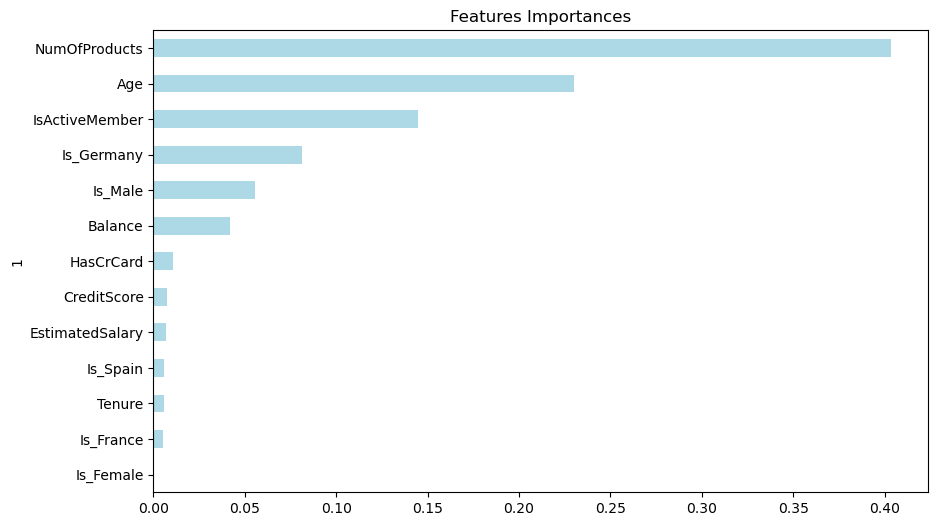

In [90]:
# Visualize the features by importance
importances_df = pd.DataFrame(sorted(zip(model.feature_importances_, X.columns), reverse=True))
importances_df.set_index(importances_df[1], inplace=True)
importances_df.drop(columns=1, inplace=True)
importances_df.rename(columns={0: 'Feature Importances'}, inplace=True)
importances_sorted = importances_df.sort_values(by='Feature Importances')
df_plot = importances_sorted.plot(kind='barh', color='lightblue', title= 'Features Importances', legend=False, figsize=(10, 6))

In [91]:
# Save the plot as a PNG file
df_plot.figure.savefig('feature_importance.png')

In [92]:
#save df to file
importances_df.to_csv("XGBoost_feature_importance.csv")

In [93]:
# save the model to disk
filename = 'XGBoost_model'
joblib.dump(model, filename)

['XGBoost_model']